**Pada program kali ini, data akan diambil dengan melalui dua cara. Cara pertama adalah dengan menggunakan API coronavirus dan cara kedua adalah pengambilan data csv terbaru melalui https://github.com/CSSEGISandData/COVID-19.**

In [1]:
!pip install coronavirus

In [2]:
!apt-get install libgeos
!apt-get install libgeos-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [3]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip

     - 208.8MB 443kB/s
     |████████████████████████████████| 10.4MB 4.1MB/s 
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756023 sha256=9f4a6c296829e27ab739019a6da7136d025285755ef5485fd7f3e3618f091213
  Stored in directory: /tmp/pip-ephem-wheel-cache-ms9v_vzq/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


In [4]:
!pip install pyproj==1.9.6

     |████████████████████████████████| 2.8MB 4.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702107 sha256=39a3d6d3ba488b53d33340eae93ae0a1a184e58144d2233a7c950ceda1152694
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.6.0
    Uninstalling pyproj-2.6.0:
      Successfully uninstalled pyproj-2.6.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta as td

%matplotlib inline

import asyncio
import aiohttp

from coronavirus import get_cases

In [0]:
async def getData():
  session = aiohttp.ClientSession()
  cases = await get_cases(session)
  country,confirmed,deaths,recovered,latitude,longitude = [],[],[],[],[],[]
  for case in cases:
    #print(f"Cases in {case.country}: {case.confirmed}")
    #attr of case = id, country, confirmed, deaths, recovered, latitude, longitude, updated
    country.append(case.country)
    confirmed.append(case.confirmed)
    deaths.append(case.deaths)
    recovered.append(case.recovered)
    latitude.append(case.latitude)
    longitude.append(case.longitude)
    await session.close()
  df = pd.DataFrame({"Country":country,"Confirmed":confirmed,"Deaths":deaths,"Recovered":recovered,"Latitude":latitude,"Longitude":longitude})
  return df

In [7]:
  loop = asyncio.get_event_loop()
  dfCovid = loop.run_until_complete(getData())
  dfCovid.head()

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Australia,1562,7,119,-25.0000,133.0000
1,Austria,3582,16,9,47.5162,14.5501
2,Canada,1469,21,0,60.0010,-95.0010
3,China,81454,3274,72817,30.5928,114.3055
4,Denmark,1514,13,4,56.0000,10.0000


In [8]:
dfCovid["Death Rate(%)"] = round((dfCovid["Deaths"]/dfCovid["Confirmed"])*100,2)
dfCovid["Not Recovered"] = dfCovid["Confirmed"] - dfCovid["Recovered"] - dfCovid["Deaths"]
dfCovid.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,Australia,1562,7,119,-25.0000,133.0000,0.45,1436
1,Austria,3582,16,9,47.5162,14.5501,0.45,3557
2,Canada,1469,21,0,60.0010,-95.0010,1.43,1448


In [9]:
df_sort_confirmed = dfCovid.sort_values(["Confirmed"],ascending=False)
df_sort_confirmed = df_sort_confirmed.reset_index(drop=True)
df_sort_confirmed.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,China,81454,3274,72817,30.5928,114.3055,4.02,5363
1,Italy,59138,5476,7024,41.8719,12.5674,9.26,46638
2,US,35224,471,0,40.0000,-100.0000,1.34,34753


In [10]:
df_sort_deathrate = dfCovid.sort_values(["Death Rate(%)"],ascending=False)
df_sort_deathrate = df_sort_deathrate.reset_index(drop=True)
df_sort_deathrate.head(3)

,Country,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
0,Sudan,2,1,0,12.8628,30.2176,50.00,1
1,Gabon,5,1,0,-0.8037,11.6094,20.00,4
2,San Marino,175,20,4,43.9424,12.4578,11.43,151


**Melakukan plotting terhadap persebaran COVID-19 per negara (Data API coronavirus)**

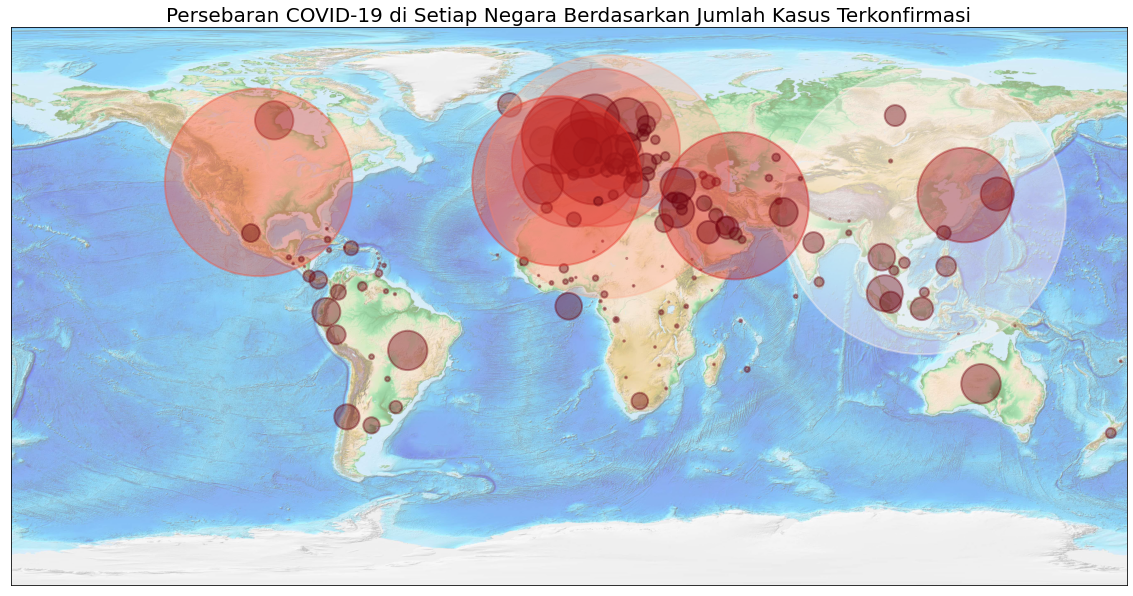

In [47]:
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.etopo(scale=0.5, alpha=0.5)
plt.title("Persebaran COVID-19 di Setiap Negara Berdasarkan Jumlah Kasus Terkonfirmasi", fontsize='20')
x, y = m(dfCovid["Longitude"].values, dfCovid["Latitude"].values)
plt.scatter(x, y, s=dfCovid["Confirmed"].values, c=dfCovid["Confirmed"].values, cmap="Reds_r", alpha=0.4, linewidth=2)
plt.show()

**Melakukan plotting terhadap penderita COVID-19 pada sepuluh negara dengan kasus terkonfirmasi terbanyak**

In [12]:
top_ten_confirmed = df_sort_confirmed.iloc[0:10,:].copy()
top_ten_confirmed = top_ten_confirmed.set_index("Country")
top_ten_confirmed.head() 

,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
Country,,,,,,,
China,81454,3274,72817,30.592800,114.30550,4.02,5363
Italy,59138,5476,7024,41.871900,12.56740,9.26,46638
US,35224,471,0,40.000000,-100.00000,1.34,34753
Spain,28768,1772,2575,40.463667,-3.74922,6.16,24421
Germany,24873,94,266,51.165700,10.45150,0.38,24513


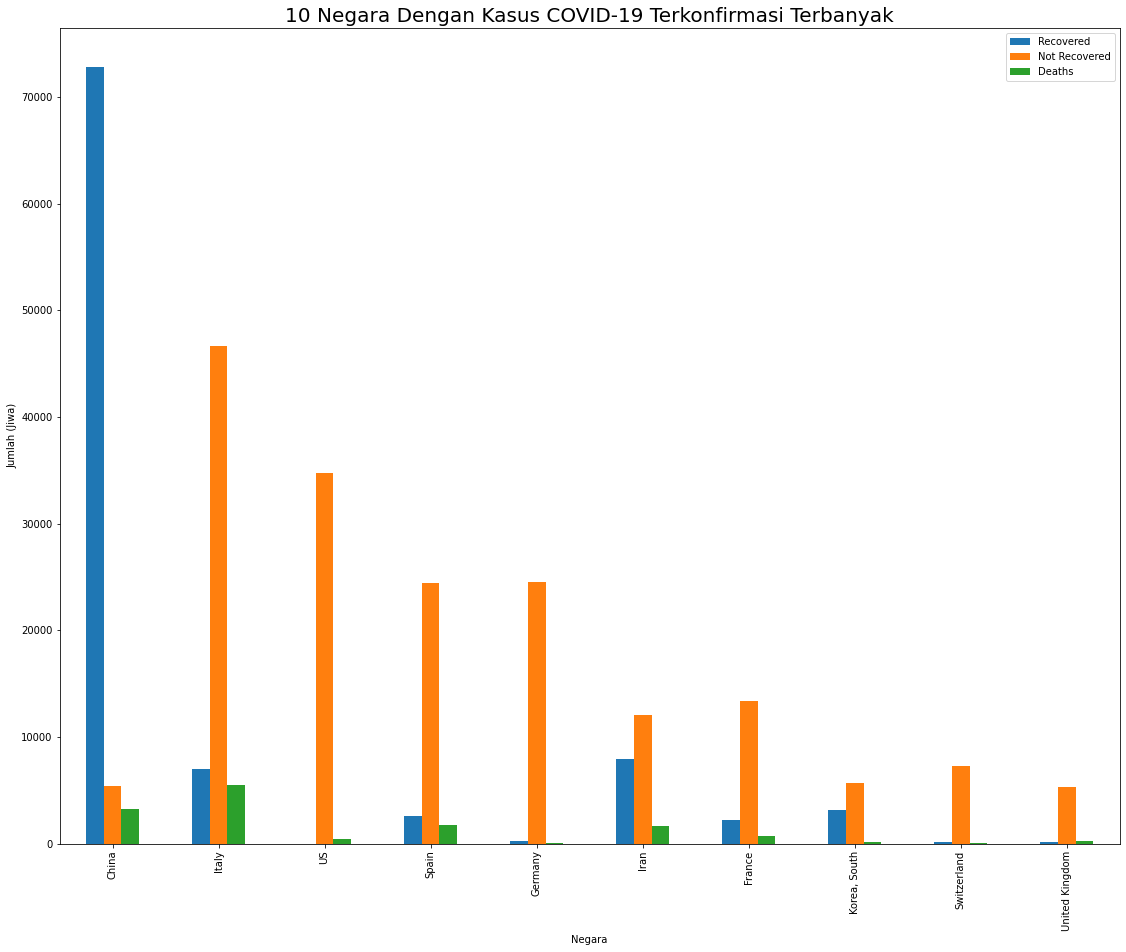

In [13]:
top_ten_confirmed[["Recovered","Not Recovered","Deaths"]].plot.bar(stacked=False)
plt.gcf().set_size_inches(19, 15)
plt.title("10 Negara Dengan Kasus COVID-19 Terkonfirmasi Terbanyak", fontsize = 20)
plt.xlabel("Negara")
plt.ylabel("Jumlah (Jiwa)")
plt.show()

**Melakukan plotting terhadap 10 negara dengan tingkat kematian tertinggi (kasus terkonfirmasi > 1000)**

In [14]:
top_ten_deathrate_thousand = dfCovid[dfCovid["Confirmed"]>1000]
top_ten_deathrate_thousand = top_ten_deathrate_thousand.sort_values(["Death Rate(%)"], ascending=False)
top_ten_deathrate_thousand = top_ten_deathrate_thousand.iloc[0:10,:].copy()
top_ten_deathrate_thousand = top_ten_deathrate_thousand.set_index("Country")
top_ten_deathrate_thousand.head() 

,Confirmed,Deaths,Recovered,Latitude,Longitude,Death Rate(%),Not Recovered
Country,,,,,,,
Italy,59138,5476,7024,41.871900,12.567400,9.26,46638
Iran,21638,1685,7913,32.427908,53.688046,7.79,12040
Spain,28768,1772,2575,40.463667,-3.749220,6.16,24421
United Kingdom,5745,282,137,55.000000,-3.000000,4.91,5326
Netherlands,4217,180,3,52.316700,5.550000,4.27,4034


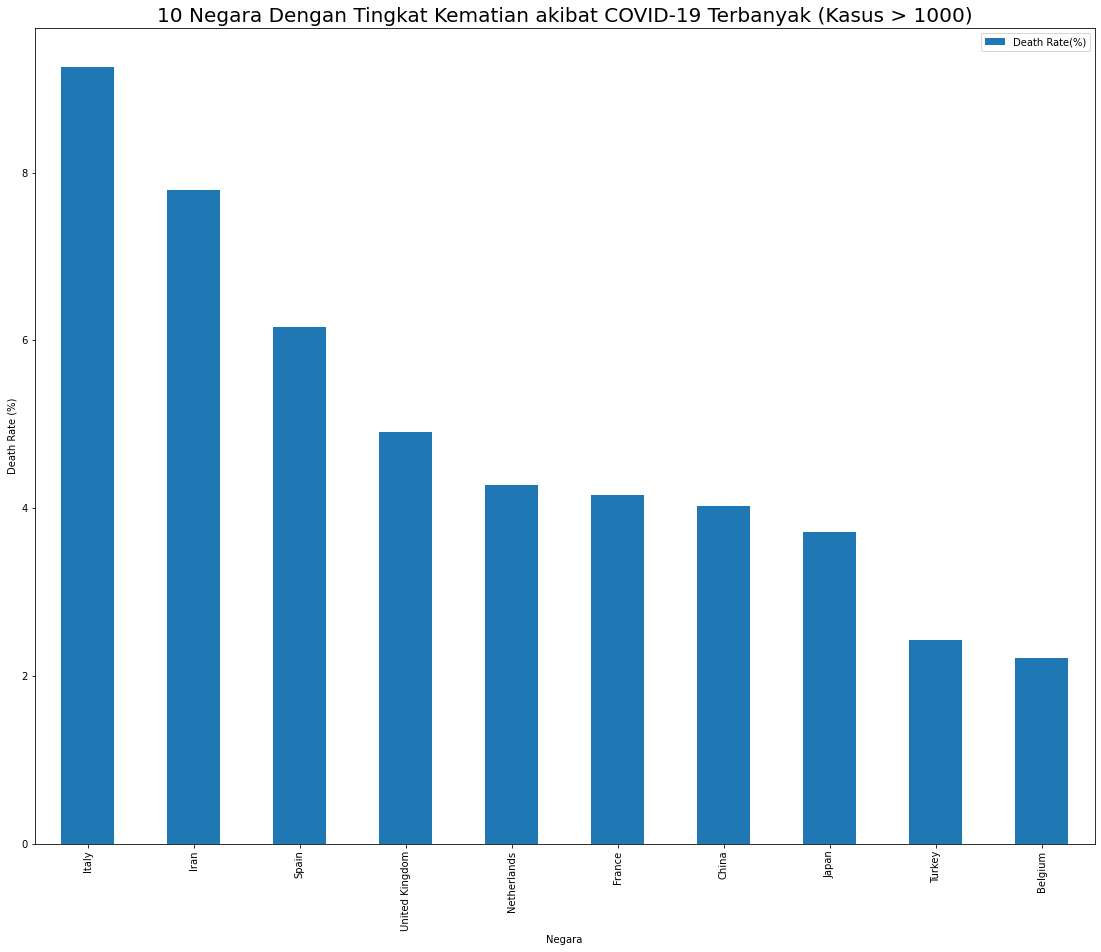

In [15]:
top_ten_deathrate_thousand[["Death Rate(%)"]].plot.bar()
plt.gcf().set_size_inches(19, 15)
plt.title("10 Negara Dengan Tingkat Kematian akibat COVID-19 Terbanyak (Kasus > 1000)", fontsize = 20)
plt.xlabel("Negara")
plt.ylabel("Death Rate (%)")
plt.show()

**Melakukan plotting terhadap persebaran COVID-19 per provinsi (Data https://github.com/CSSEGISandData/COVID-19)**

In [0]:
date = str(dt.strftime(dt.now() - td(1), '%m-%d-%Y'))

In [0]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"+date+".csv"

In [0]:
CovDetail = pd.read_csv(url)

In [19]:
CovDetail.head(3)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-22T09:43:06,67800,3144,59433,30.9756,112.2707
1,NaN,Italy,2020-03-22T18:13:20,59138,5476,7024,41.8719,12.5674
2,NaN,Spain,2020-03-22T23:13:18,28768,1772,2575,40.4637,-3.7492


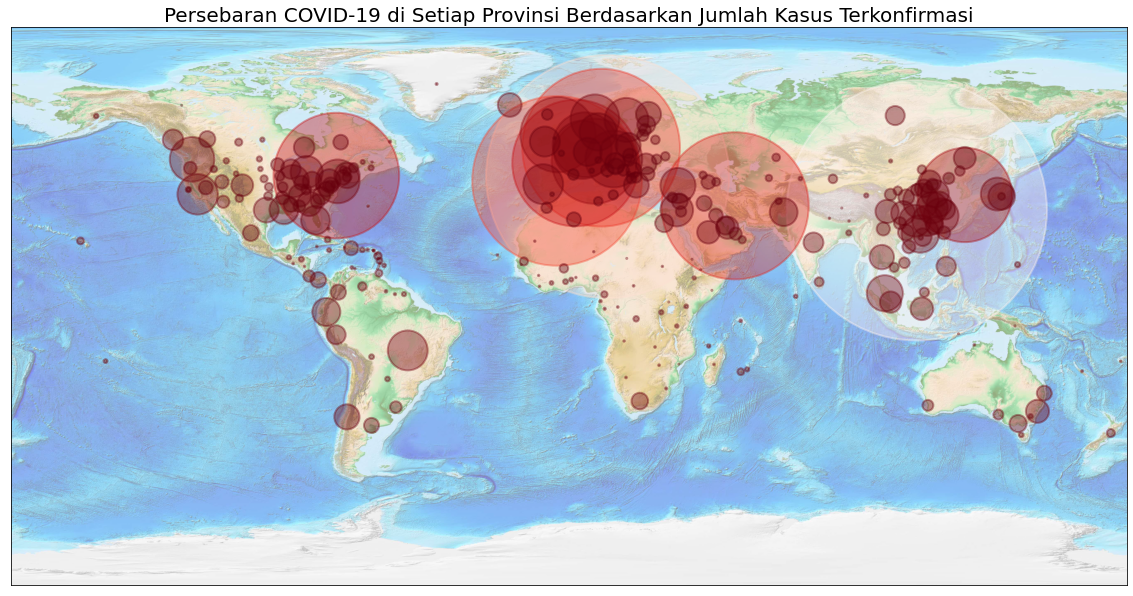

In [48]:
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.etopo(scale=0.5, alpha=0.5)
plt.title("Persebaran COVID-19 di Setiap Provinsi Berdasarkan Jumlah Kasus Terkonfirmasi", fontsize='20')
x, y = m(CovDetail["Longitude"].values, CovDetail["Latitude"].values)
plt.scatter(x, y, s=CovDetail["Confirmed"].values, c=CovDetail["Confirmed"].values, cmap="Reds_r", alpha=0.4, linewidth=2)
plt.show()

In [21]:
CovDetail["Last Update"]= CovDetail["Last Update"].str.slice(0, 10, 1)
CovDetail.head()  

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-22,67800,3144,59433,30.9756,112.2707
1,NaN,Italy,2020-03-22,59138,5476,7024,41.8719,12.5674
2,NaN,Spain,2020-03-22,28768,1772,2575,40.4637,-3.7492
3,NaN,Germany,2020-03-22,24873,94,266,51.1657,10.4515
4,NaN,Iran,2020-03-22,21638,1685,7931,32.4279,53.6880


**Grafik Time-Series suatu negara terhadap kasus terkonfirmasi, kematian, dan kesembuhan pada COVID-19 (Data https://github.com/CSSEGISandData/COVID-19)**

In [0]:
dfConfirmedTimeSeries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
dfDeathsTimeSeries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
dfRecoveredTimeSeries = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

In [23]:
dfConfTS = pd.DataFrame(dfConfirmedTimeSeries.groupby("Country/Region")[dfConfirmedTimeSeries.columns[list(dfConfirmedTimeSeries.columns).index("Long")+1:]].sum())
dfConfTS = dfConfTS.reset_index(drop=False)
dfConfTS.sort_values(dfConfTS.columns[-1],ascending=False).head(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
33,China,548,643,920,1406,2075,2877,5509,6087,8141,9802,11891,16630,19716,23707,27440,30587,34110,36814,39829,42354,44386,44759,59895,66358,68413,70513,72434,74211,74619,75077,75550,77001,77022,77241,77754,78166,78600,78928,79356,79932,80136,80261,80386,80537,80690,80770,80823,80860,80887,80921,80932,80945,80977,81003,81033,81058,81102,81156,81250,81305,81397
81,Italy,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578,59138
160,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,217,262,402,518,583,959,1281,1663,2179,2727,3499,4632,6421,7783,13677,19100,25489,33272


In [24]:
dfDeathTS = pd.DataFrame(dfDeathsTimeSeries.groupby("Country/Region")[dfDeathsTimeSeries.columns[list(dfDeathsTimeSeries.columns).index("Long")+1:]].sum())
dfDeathTS = dfDeathTS.reset_index(drop=False)
dfDeathTS.sort_values(dfDeathTS.columns[-1],ascending=False).head(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
81,Italy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,7,10,12,17,21,29,34,52,79,107,148,197,233,366,463,631,827,827,1266,1441,1809,2158,2503,2978,3405,4032,4825,5476
33,China,17,18,26,42,56,82,131,133,171,213,259,361,425,491,563,633,718,805,905,1012,1112,1117,1369,1521,1663,1766,1864,2003,2116,2238,2238,2443,2445,2595,2665,2717,2746,2790,2837,2872,2914,2947,2983,3015,3044,3072,3100,3123,3139,3161,3172,3180,3193,3203,3217,3230,3241,3249,3253,3259,3265
145,Spain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,5,10,17,28,35,54,55,133,195,289,342,533,623,830,1043,1375,1772


In [25]:
dfRecovTS = pd.DataFrame(dfRecoveredTimeSeries.groupby("Country/Region")[dfRecoveredTimeSeries.columns[list(dfRecoveredTimeSeries.columns).index("Long")+1:]].sum())
dfRecovTS = dfRecovTS.reset_index(drop=False)
dfRecovTS.sort_values(dfRecovTS.columns[-1],ascending=False).head(3)

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
33,China,28,30,36,39,49,58,101,120,135,214,275,463,614,843,1115,1477,1999,2596,3219,3918,4636,5082,6217,7977,9298,10755,12462,14206,15962,18014,18704,22699,23187,25015,27676,30084,32930,36329,39320,42162,44854,47450,50001,52292,53944,55539,57388,58804,60181,61644,62901,64196,65660,67017,67910,68798,69755,70535,71266,71857,72362
77,Iran,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,49,73,123,175,291,291,552,739,913,1669,2134,2394,2731,2959,2959,2959,2959,4590,4590,5389,5389,5710,6745,7635,7931
81,Italy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,1,3,45,46,46,83,149,160,276,414,523,589,622,724,724,1045,1045,1439,1966,2335,2749,2941,4025,4440,4440,6072,7024


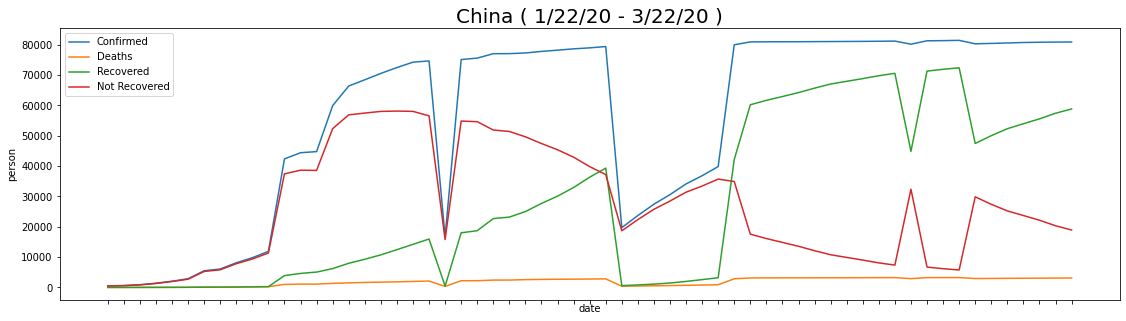

In [26]:
Country = "China"
liConf = list(dfConfTS[dfConfTS["Country/Region"]==Country].values[0][1:])
liDeath = list(dfDeathTS[dfDeathTS["Country/Region"]==Country].values[0][1:])
liRecov = list(dfRecovTS[dfRecovTS["Country/Region"]==Country].values[0][1:])
liNotRecov = list(np.array(liConf)-np.array(liDeath)-np.array(liRecov))
ax = sns.lineplot(x=list(dfConfTS.columns[1:]), y=liConf, label="Confirmed")
ax = sns.lineplot(x=list(dfDeathTS.columns[1:]), y=liDeath, label="Deaths")
ax = sns.lineplot(x=list(dfRecovTS.columns[1:]), y=liRecov, label="Recovered")
ax = sns.lineplot(x=list(dfRecovTS.columns[1:]), y=liNotRecov, label="Not Recovered")
plt.gcf().set_size_inches(19, 5)
plt.tick_params(labelbottom=False)
plt.title(Country+" ( "+dfConfTS.columns[1]+" - "+dfConfTS.columns[-1]+" )",fontsize=20)
plt.ylabel("person")
plt.xlabel("date")
plt.show()

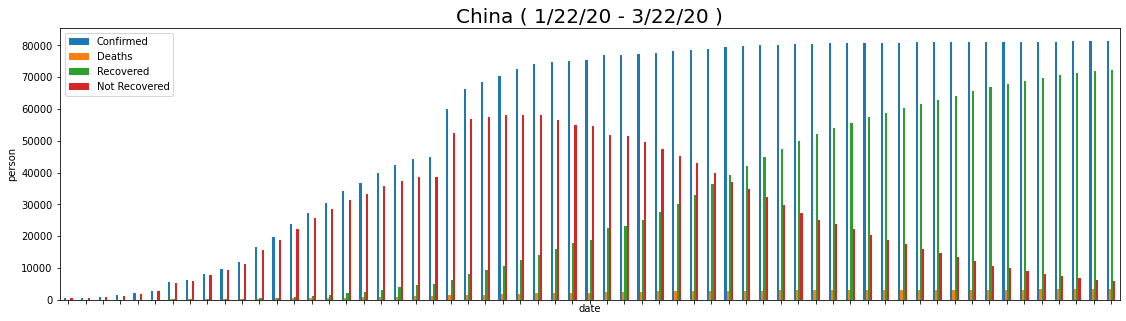

In [27]:
report = pd.DataFrame({"Date":list(dfConfTS.columns[1:]),"Confirmed":liConf,"Deaths":liDeath,"Recovered":liRecov,"Not Recovered":liNotRecov})
report[["Confirmed","Deaths","Recovered","Not Recovered"]].plot.bar(stacked=False)
plt.gcf().set_size_inches(19, 5)
plt.tick_params(labelbottom=False)
plt.title(Country+" ( "+dfConfTS.columns[1]+" - "+dfConfTS.columns[-1]+" )",fontsize=20)
plt.ylabel("person")
plt.xlabel("date")
plt.show()